In [1]:
# import libraries
from ucimlrepo import fetch_ucirepo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Explorative Datenanalyse
Deskriptive Statistik: Berechnung von Mittelwerten, Mediane, Standardabweichungen und anderen Kenngrößen für die verschiedenen Merkmale.  
Visualisierung: Nutzung von Histogrammen, Boxplots und Scatterplots, um die Verteilung und Beziehungen der Merkmale zu analysieren.  
Korrelation: Untersuchung der Korrelation zwischen den Merkmalen und dem Outcome.

### Dataset preparation

In [85]:
# fetch dataset 
heart_disease = fetch_ucirepo(id=45)

# features
x = heart_disease.data.features 

# target variable
y = heart_disease.data.targets 

# complete dataframe
heart_df = pd.concat([x, y], axis=1).rename(columns={'num':'healthy'})

# replace values for target variable: 0=sick, 1=healthy
heart_df['healthy'] = heart_df['healthy'].replace({0: 1, 1: 0, 2: 0, 3: 0, 4: 0})

# view summary of dataset
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  healthy   303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


In [4]:
# data cleaning
rows_with_nan = heart_df.isna().any(axis=1).sum()
print(f"Number of rows with NaN values to be removed: {rows_with_nan}")
total_rows = heart_df.shape[0]
print(f"Total number of rows: {total_rows}")

# remove rows with NaN values
heart_df = heart_df.dropna()

heart_df

Number of rows with NaN values to be removed: 6
Total number of rows: 303


age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1       145   233    1        2      150      0      2.3   
1     67    1   4       160   286    0        2      108      1      1.5   
2     67    1   4       120   229    0        2      129      1      2.6   
3     37    1   3       130   250    0        0      187      0      3.5   
4     41    0   2       130   204    0        2      172      0      1.4   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
297   57    0   4       140   241    0        0      123      1      0.2   
298   45    1   1       110   264    0        0      132      0      1.2   
299   68    1   4       144   193    1        0      141      0      3.4   
300   57    1   4       130   131    0        0      115      1      1.2   
301   57    0   2       130   236    0        2      174      0      0.0   

     slope   ca  thal  healthy  
0        3  0.0   6.0        1  
1        2  3.0   3.0        0  
2        2  2.0   7.0        0  
3        3  0.0   3.0        1  
4        1  0.0   3.0        1  
..     ...  ...   ...      ...  
297      2  0.0   7.0        0  
298      2  0.0   7.0        0  
299      2  2.0   7.0        0  
300      2  1.0   7.0        0  
301      2  1.0   3.0        0  

[297 rows x 14 columns]

### Clustering and PCA
Um zu analysieren, ob ähnliche Merkmale auch zur gleichen Diagnose führen, wird zuerst ein k-Means Clustering angewandt.

In [6]:
# prepare data for clustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# split data into featrues (x) and targets (y)
X = heart_df.iloc[:, :-1]
y = heart_df.iloc[:, -1]

# scale data (MinMax probieren)
scaler = StandardScaler() 
X_scaled = scaler.fit_transform (X)

In [7]:
# k-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

# prepare model
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
kmeans.fit(X_scaled)

KMeans(n_clusters=2, n_init='auto', random_state=42)

In [14]:
# calculate percentage of data points correctly assigned to each cluster
cluster1 = kmeans.labels_ == 0
cluster2 = kmeans.labels_ == 1

perc_cluster1 = np.round(np.mean(cluster1 == y) * 100, decimals=2)
perc_cluster2 = np.round(np.mean(cluster2 == y) * 100, decimals=2)

# choose cluster with higher correspondence
if perc_cluster1 > perc_cluster2:
    km_healthy = cluster1
    max_perc = perc_cluster1
else:
    km_healthy = cluster2
    max_perc = perc_cluster2

print(f"{max_perc}% der Datensätze wurden mithilfe von KMeans richtig einem Cluster zugeordnet")

# hier vlt noch irgendwie diskutieren ob das ein smart way ist um das auszuwerten, anscheinend gibt's dafür andere Metriken

79.12% der Datensätze wurden mithilfe von KMeans richtig einem Cluster zugeordnet


Proportion of variance explained by each principal component:
[0.23695056 0.12349486 0.0960383  0.0851614  0.07638123 0.06720242
 0.06493755 0.05994447 0.05268635 0.04368496 0.03486402 0.03140469
 0.02724919]


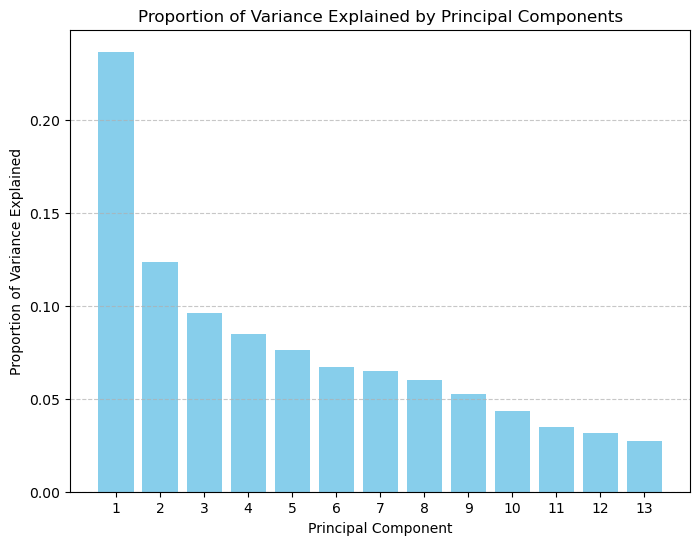

In [50]:
# apply PCA
pca = PCA()
pca.fit(X_scaled)

print(f"Proportion of variance explained by each principal component:\n{pca.explained_variance_ratio_}")

# Plot the proportion of variance explained
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Proportion of Variance Explained by Principal Components')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [48]:
# get the loadings or weights of features in the first principal component
first_pc_loadings = pca.components_[0]

# create a DataFrame to display the contributions of features to the first principal component
pc_loadings_df = pd.DataFrame({"Feature": X.columns, "Contribution": first_pc_loadings})
pc_loadings_df = pc_loadings_df.sort_values(by="Contribution", ascending=False)

print("Contributions of features to the first principal component:")
print(pc_loadings_df)

Contributions of features to the first principal component:
     Feature  Contribution
9    oldpeak      0.397006
10     slope      0.352024
12      thal      0.346208
8      exang      0.333140
11        ca      0.306420
2         cp      0.286212
0        age      0.285868
3   trestbps      0.167841
6    restecg      0.145938
1        sex      0.116802
4       chol      0.083504
5        fbs      0.076094
7    thalach     -0.392706


#### Interpretation:
Die "Proportion of Variance Explained by Principal Components" gibt an, wie viel der gesamten Varianz in den Daten durch jede einzelne Hauptkomponente erklärt wird.
Hauptkomponenten mit einer höheren Proportion der erklärten Varianz tragen mehr zur Erklärung der Variation in den Daten bei und sind daher wichtiger.
Eine höhere Proportion der erklärten Varianz in einer bestimmten Hauptkomponente kann darauf hinweisen, dass diese Hauptkomponente wichtige Informationen über die Variation in den Merkmalen oder Beobachtungen enthält, die mit den zugrunde liegenden Mustern oder Gruppierungen in den Herzdaten zusammenhängen könnten. Dabei ist wichtig zu erwähnen, dass die Ergebnisse nicht in direktem Zusammenhang mit der goal-Variable stehen, sondern lediglich auf Muster in den Daten hinweisen.

Merkmale, die hohe Contributions zu der ersten Hauptkomponente haben, tragen wesentlich zur Variation in den Daten bei. Diese Merkmale haben möglicherweise eine starke Korrelation mit der ersten Hauptkomponente und könnten daher wichtigere Informationen über die zugrunde liegenden Muster oder Strukturen in den Daten liefern, als jene mit einer geringen Contribution.

### Cholesterinwerte im Vergleich Frauen/Männer

/Users/nicole/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicole/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicole/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


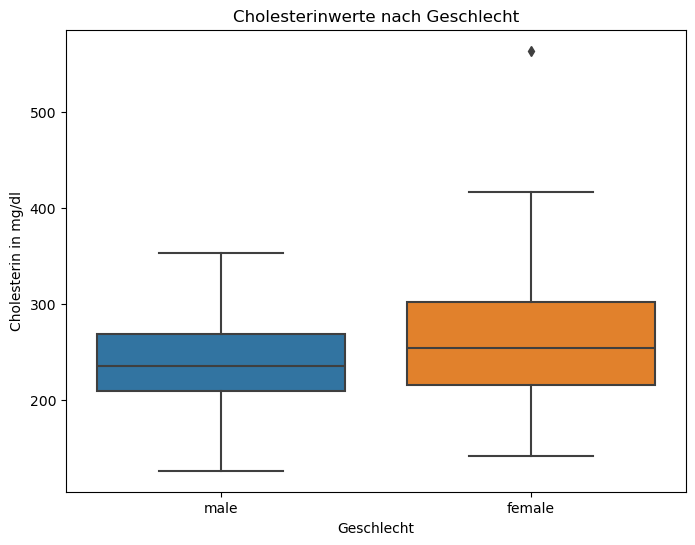

In [97]:
heart_df['sex'] = heart_df['sex'].replace({0: 'female', 1: 'male'})
plt.figure(figsize=(8, 6))
sns.boxplot(x='sex', y='chol', data=heart_df)
plt.title('Cholesterinwerte nach Geschlecht')
plt.xlabel('Geschlecht')
plt.ylabel('Cholesterin in mg/dl')
plt.show()

In [65]:
# Konfidenzintervall (95%) für Cholesterin Level jeweils für Männer und Frauen
from scipy import stats

# Filtern nach Geschlecht und Berechnen des Konfidenzintervalls
conf_level = 0.95
chol_men = heart_df.loc[heart_df['sex'] == 'male', 'chol']
chol_women = heart_df.loc[heart_df['sex'] == 'female', 'chol']
conf_int_men = stats.t.interval(conf_level, len(chol_men) - 1, loc=chol_men.mean(), scale=stats.sem(chol_men))
conf_int_women = stats.t.interval(conf_level, len(chol_women) - 1, loc=chol_women.mean(), scale=stats.sem(chol_women))

result_table_men_vs_women = pd.DataFrame({
    'Geschlecht': ['Männer', 'Frauen'],
    'Untere_Grenze': [conf_int_men[0], conf_int_women[0]],
    'Obere_Grenze': [conf_int_men[1], conf_int_women[1]]
})

print(result_table_men_vs_women)

  Geschlecht  Untere_Grenze  Obere_Grenze
0     Männer     234.288517    246.199046
1     Frauen     249.044612    275.413721


### Cholesterin im Vergleich zur Erkrankung

/Users/nicole/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicole/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicole/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


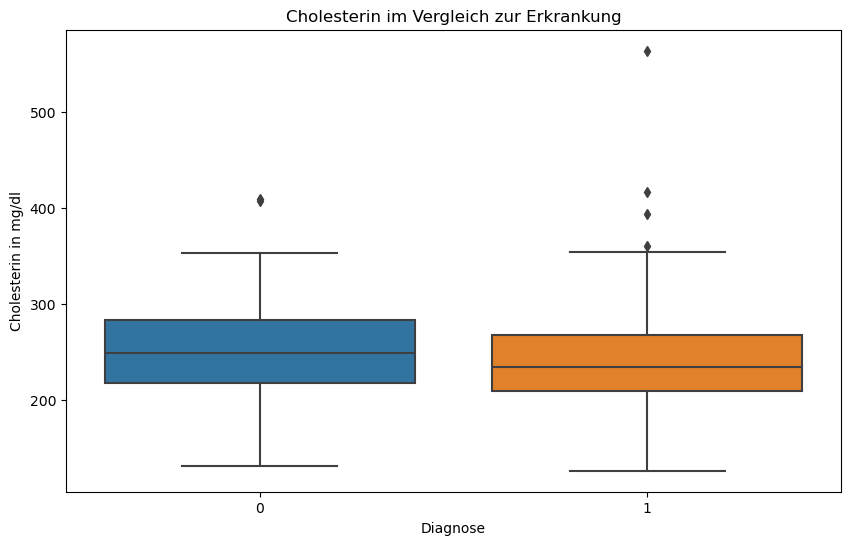

In [87]:
# Boxplot gruppiert nach Diagnose
plt.figure(figsize=(10, 6))
sns.boxplot(x='healthy', y='chol', data=heart_df)
plt.title('Cholesterin im Vergleich zur Erkrankung')
plt.xlabel('Diagnose')
plt.ylabel('Cholesterin in mg/dl')
plt.show()

In [91]:
# Filtern nach healthy und Berechnen des Konfidenzintervalls
conf_level = 0.95
chol_healthy = heart_df.loc[heart_df['healthy'] == 1, 'chol']
chol_sick = heart_df.loc[heart_df['healthy'] == 0, 'chol']
conf_int_healthy = stats.t.interval(conf_level, len(chol_healthy) - 1, loc=chol_healthy.mean(), scale=stats.sem(chol_healthy))
conf_int_sick = stats.t.interval(conf_level, len(chol_sick) - 1, loc=chol_sick.mean(), scale=stats.sem(chol_sick))

result_table_healthy_vs_sick = pd.DataFrame({
    'Diagnose': ['Gesund', 'Krank'],
    'Untere_Grenze': [conf_int_healthy[0], conf_int_sick[0]],
    'Obere_Grenze': [conf_int_healthy[1], conf_int_sick[1]]
})

print(result_table_healthy_vs_sick)

  Diagnose  Untere_Grenze  Obere_Grenze
0   Gesund     234.397652    250.882836
1    Krank     243.175250    259.774391


In [93]:
# t-Test
# Nullhypothese (HO) = Cholesterinwert bei Kranken ist gleich oder kleiner wie bei Gesunden
# Alternativhypothese (H1) Cholesterinwert bei Kranken ist höher als bei Gesunden

from scipy.stats import ttest_ind

# Daten für gesunde und kranke Personen
chol_healthy = heart_df.loc[heart_df['healthy'] == 1, 'chol']
chol_sick = heart_df.loc[heart_df['healthy'] == 0, 'chol']

# Durchführung des t-Tests
t_statistic, p_value = ttest_ind(chol_sick, chol_healthy, alternative='greater')

# Ausgabe der Ergebnisse
print("t-Statistik:", t_statistic)
print("p-Wert:", p_value)

# Überprüfung der Nullhypothese
if p_value < 0.05:
    print("Der p-Wert ist kleiner als 0.05, daher wird die Nullhypothese abgelehnt.")
    print("Es gibt signifikante Hinweise darauf, dass der Cholesterinwert bei kranken Personen höher ist als bei gesunden Personen.")
else:
    print("Der p-Wert ist größer als oder gleich 0.05, daher wird die Nullhypothese nicht abgelehnt.")
    print("Es gibt keine signifikanten Hinweise darauf, dass der Cholesterinwert bei kranken Personen höher ist als bei gesunden Personen.")

t-Statistik: 1.4829209163941466
p-Wert: 0.06957083510218263
Der p-Wert ist größer als oder gleich 0.05, daher wird die Nullhypothese nicht abgelehnt.
Es gibt keine signifikanten Hinweise darauf, dass der Cholesterinwert bei kranken Personen höher ist als bei gesunden Personen.


### Systolischer Ruheblutdruck

/Users/nicole/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicole/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicole/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


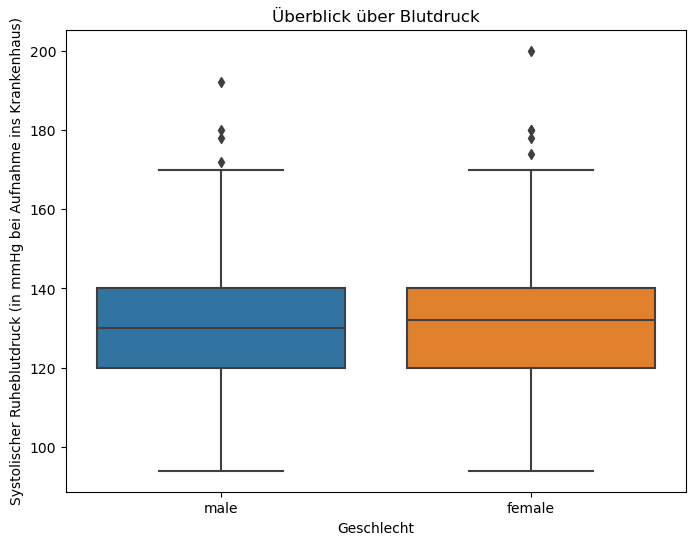

In [99]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='sex', y='trestbps', data=heart_df)
plt.title('Überblick über Blutdruck')
plt.xlabel('Geschlecht')
plt.ylabel('Systolischer Ruheblutdruck (in mmHg bei Aufnahme ins Krankenhaus)')
plt.show()

In [101]:
# Filtern nach goal und Berechnen des Konfidenzintervalls
conf_level = 0.95
blutdruck_gesund = heart_df.loc[heart_df['healthy'] == 1, 'trestbps']
blutdruck_krank = heart_df.loc[heart_df['healthy'] == 0, 'trestbps']
conf_int_gesund = stats.t.interval(conf_level, len(blutdruck_gesund) - 1, loc=blutdruck_gesund.mean(), scale=stats.sem(blutdruck_gesund))
conf_int_krank = stats.t.interval(conf_level, len(blutdruck_krank) - 1, loc=blutdruck_krank.mean(), scale=stats.sem(blutdruck_krank))

# Erstellen der Tabelle
result_table_blutdruck = pd.DataFrame({
    'Diagnose': ['Gesund', 'Krank'],
    'Untere_Grenze': [conf_int_gesund[0], conf_int_krank[0]],
    'Obere_Grenze': [conf_int_gesund[1], conf_int_krank[1]]
})

# Anzeige der Tabelle
print(result_table_blutdruck)

  Diagnose  Untere_Grenze  Obere_Grenze
0   Gesund     126.751354    131.748646
1    Krank     131.420542    137.716148


In [111]:
# t-Test
# H0 Kranke haben einen niedrigeren oder gleichen Blutdruck wie Gesunde
# H1 Kranke haben einen höheren BLutdruck als Gesunde

# Daten für gesunde und kranke Personen
blutdruck_healthy = heart_df.loc[heart_df['healthy'] == 1, 'trestbps']
blutdruck_sick = heart_df.loc[heart_df['healthy'] == 0, 'trestbps']

# Durchführung des t-Tests
t_statistic, p_value = ttest_ind(blutdruck_sick, blutdruck_healthy, alternative='greater')

print("t-Statistik:", t_statistic)
print("p-Wert:", p_value)

# Überprüfung Nullhypothese
if p_value < 0.05:
    print("Der p-Wert ist kleiner als 0.05, daher wird die Nullhypothese abgelehnt.")
    print("Es gibt signifikante Hinweise darauf, dass der Blutdruck bei kranken Personen höher ist als bei gesunden Personen.")
else:
    print("Der p-Wert ist größer als oder gleich 0.05, daher wird die Nullhypothese nicht abgelehnt.")
    print("Es gibt keine signifikanten Hinweise darauf, dass der Blutdruck bei kranken Personen höher ist als bei gesunden Personen.")

t-Statistik: 2.647004396805282
p-Wert: 0.004274134464297464
Der p-Wert ist kleiner als 0.05, daher wird die Nullhypothese abgelehnt.
Es gibt signifikante Hinweise darauf, dass der Blutdruck bei kranken Personen höher ist als bei gesunden Personen.


### Weitere Dinge die wir machen könnten
- Korrelationsanalyse
- logistische Regression, KNN, Entscheidungsbäume
- ROC/AUC Kurve plotten für Modelle



- Classification:
- SVMs
- Decision Trees
- K-Nearest Neighbor
- Random Forest

Dimensionality Reduction
- PCA

Regression:
- lineare 
- logistische

Clustering:
- hierarchisch -> bäume
- K-means clustering

Statistik:
- Hypothesen